# Imports

In [234]:
from INMET import INMET
from ONI import ONI

In [235]:
import pandas as pd
from pathlib import Path
import csv
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from TratamentoDados import gerar_daily_dataframe
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Tratamento dados INMET

In [236]:
#inmet = INMET()
#inmet.extrair_dados_inmet()

# Tratamento dados ONI

In [237]:
oni = ONI()
oni.extrair_dados()

# Criação de dataframe

In [238]:
def list_cities(diretorio_regiao):
    directories = []
    dir_path = Path(diretorio_regiao)

    cidades = [item.name for item in dir_path.iterdir() if item.is_dir()]

    return cidades

In [239]:
def anexacao_dados_medidor(diretorio_regiao):
    cidades = list_cities(diretorio_regiao)

    for cidade in cidades:
        diretorio_completo = f"{diretorio_regiao}{cidade}/"
        dir_path = Path(diretorio_completo)

        files = [item.name for item in dir_path.iterdir() if item.is_file()]

        column_names = None

        rows = []

        for file_name in files:
            with open(f'{diretorio_completo}{file_name}', 'r') as csv_file:
                for row in csv_file.readlines():
                    if 'data' in row.lower():
                        if column_names is None:
                            column_names = row.split(',')
                            continue
                    
                    else:
                        rows.append(row.split(','))

        with open(f'{diretorio_regiao}{cidade}.csv', 'w') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(column_names)

            for row in rows:
                writer.writerow(row)


In [240]:
anexacao_dados_medidor('/home/iury/Especializacao/Modelos_Machine_Learning/INMET/RS/')

In [241]:
daily_df = gerar_daily_dataframe('/home/iury/Especializacao/Modelos_Machine_Learning/INMET/RS/PORTO ALEGRE.csv')

# Seleção de features

In [242]:
daily_df.corr()

,precipitacao,pressao_atmosferica,radiacao_global,temperatura_do_ar,temperatura_ponto_orvalho,umidade,direcao_vento_horario,vento_rajada_maxima,vento_velocidade_horaria,year,month,day,la_nina,el_nino,num_observacoes
precipitacao,1.000000,-0.109976,-0.335470,-0.049284,0.148755,0.434043,0.026585,0.175596,0.063556,0.023992,0.014813,0.004950,0.014476,0.002243,0.048279
pressao_atmosferica,-0.109976,1.000000,-0.033563,-0.353194,-0.347585,0.042652,-0.050677,-0.067453,-0.055437,0.093224,0.005689,0.002373,0.006540,-0.015391,0.101359
radiacao_global,-0.335470,-0.033563,1.000000,0.434105,0.140997,-0.619895,-0.081664,0.096505,0.138851,0.290918,0.032341,-0.005417,0.037094,0.128873,0.108180
temperatura_do_ar,-0.049284,-0.353194,0.434105,1.000000,0.883389,-0.298511,-0.137478,0.067576,0.061391,0.010013,-0.225582,-0.012290,0.025768,0.132712,0.043061
temperatura_ponto_orvalho,0.148755,-0.347585,0.140997,0.883389,1.000000,0.178588,-0.147326,0.055053,0.003495,0.069735,-0.263494,-0.012415,0.018002,0.123281,0.056828
umidade,0.434043,0.042652,-0.619895,-0.298511,0.178588,1.000000,-0.010789,-0.059707,-0.154386,0.135399,-0.049921,0.001491,-0.016246,-0.024823,0.039836
direcao_vento_horario,0.026585,-0.050677,-0.081664,-0.137478,-0.147326,-0.010789,1.000000,0.048858,0.023818,0.024585,-0.073630,-0.001458,-0.003434,-0.028421,-0.008581
vento_rajada_maxima,0.175596,-0.067453,0.096505,0.067576,0.055053,-0.059707,0.048858,1.000000,0.940015,-0.021795,0.126589,0.004399,0.027995,0.044302,0.031197
vento_velocidade_horaria,0.063556,-0.055437,0.138851,0.061391,0.003495,-0.154386,0.023818,0.940015,1.000000,-0.144849,0.117566,-0.002315,0.026023,0.028887,-0.050177
year,0.023992,0.093224,0.290918,0.010013,0.069735,0.135399,0.024585,-0.021795,-0.144849,1.000000,-0.029803,-0.000985,0.026203,0.084207,0.236612


In [243]:
#Eliminar features com correlação absoluta baixa
df_tratado = daily_df.drop(columns=['year', 'month', 'day', 'la_nina', 'el_nino', 'num_observacoes', 'vento_velocidade_horaria', 'direcao_vento_horario'])

#Eliminar features com alta correlação com outras features
df_tratado = df_tratado.drop(columns=['temperatura_do_ar', 'radiacao_global'])

In [244]:
df_tratado.corr()

,precipitacao,pressao_atmosferica,temperatura_ponto_orvalho,umidade,vento_rajada_maxima
precipitacao,1.000000,-0.109976,0.148755,0.434043,0.175596
pressao_atmosferica,-0.109976,1.000000,-0.347585,0.042652,-0.067453
temperatura_ponto_orvalho,0.148755,-0.347585,1.000000,0.178588,0.055053
umidade,0.434043,0.042652,0.178588,1.000000,-0.059707
vento_rajada_maxima,0.175596,-0.067453,0.055053,-0.059707,1.000000


# Criar DataFrame Series Temporais

In [245]:
def preencher_datas_faltantes(df, period = 1):
    coluna_datetime = 'year_month_day'
    
#    indice_datetime = df.columns.get_loc(coluna_datetime)
    data_atual = df.index[0]#[coluna_datetime]
        
    list_dataframe = []
    
    datas = []
    
    for i in range(len(df)):
        data_row = df.index[i]#[coluna_datetime]
        
        while data_atual.date() != data_row.date():
            if list_dataframe:
                list_dataframe.append(list_dataframe[-1])
#                list_dataframe[-1].index = data_atual
                datas.append(data_atual)    
            data_atual = data_atual + timedelta(days=1)
            
        list_dataframe.append(df.iloc[i].tolist())
        
        datas.append(data_atual)
        
        data_atual = data_atual + timedelta(days=1)

    df_treated = pd.DataFrame(list_dataframe, columns = df.columns)

    df_treated.index = datas
    
#    for i in range(1, period + 1):
#        df_treated[f'diff_precipitacao_{i}'] = df_treated['precipitacao_1'].diff(periods=i)
        
    df_treated = df_treated.dropna()
    
    df_treated.reset_index(inplace=True)
    
    df_treated = df_treated.rename(columns={'index': 'year_month_day'})
        
    return df_treated
            
    
    

In [246]:
def sliding_windows_df(df, period=1, scaler=StandardScaler()):
    sw_df = pd.DataFrame()

    set_of_features_sliding_window = {'pressao_atmosferica', 'temperatura_ponto_orvalho', 'umidade', 'vento_rajada_maxima', 'precipitacao'}
    target = 'precipitacao'
    
    sw_df['target'] = df['precipitacao'].shift(-(period+1)).values    
    
    for feature in set_of_features_sliding_window:
            
        for i in range(1, period+1):
            coluna = f'{feature}_{period-i+1}'
            sw_df[coluna] = df[feature].shift(-i).values

    sw_df = sw_df.dropna()

    sw_df.set_index(df.index[period+1:], inplace=True)
        
    scaled_df = pd.DataFrame(scaler.fit_transform(sw_df), columns=sw_df.columns)
    scaled_df.set_index(sw_df.index, inplace=True)   
    
    return scaled_df

In [247]:
scaler = StandardScaler()
sliding_window_size = 5
sw_df = sliding_windows_df(df_tratado, sliding_window_size, scaler)

In [248]:
sw_df.head()

,target,temperatura_ponto_orvalho_5,temperatura_ponto_orvalho_4,temperatura_ponto_orvalho_3,temperatura_ponto_orvalho_2,temperatura_ponto_orvalho_1,umidade_5,umidade_4,umidade_3,umidade_2,...,vento_rajada_maxima_5,vento_rajada_maxima_4,vento_rajada_maxima_3,vento_rajada_maxima_2,vento_rajada_maxima_1,precipitacao_5,precipitacao_4,precipitacao_3,precipitacao_2,precipitacao_1
year_month_day,,,,,,,,,,,,,,,,,,,,,
2000-09-28,-0.379869,-0.494319,-0.814100,-2.670995,-2.354683,-1.445195,0.039251,0.530716,-1.518501,-1.306294,...,-0.130573,1.518732,1.424274,-0.042997,-0.286049,2.326470,1.921465,-0.379869,-0.379869,-0.379869
2000-09-29,-0.379869,-0.813978,-2.670772,-2.353218,-1.444324,-0.745934,0.530615,-1.518713,-1.306039,-0.500613,...,1.518710,1.424003,-0.042991,-0.285920,-0.490087,1.920454,-0.380081,-0.379869,-0.379869,-0.379869
2000-09-30,-0.379869,-2.670641,-2.352997,-1.443262,-0.745282,-0.682708,-1.518947,-1.306245,-0.500451,-0.726381,...,1.423980,-0.043091,-0.285916,-0.489974,-0.740276,-0.380303,-0.380081,-0.379869,-0.379869,-0.379869
2000-10-01,-0.128381,-2.352868,-1.443049,-0.744529,-0.682075,0.073173,-1.306465,-0.500638,-0.726193,-0.991990,...,-0.043129,-0.285987,-0.489972,-0.740184,-0.235039,-0.380303,-0.380081,-0.379869,-0.379869,-0.379869
2000-10-02,-0.360524,-1.442924,-0.744322,-0.681351,0.073570,0.553502,-0.500806,-0.726385,-0.991771,0.942529,...,-0.286028,-0.490020,-0.740185,-0.234906,-0.575102,-0.380303,-0.380081,-0.379869,-0.379869,-0.128381


In [249]:
sw_df = preencher_datas_faltantes(sw_df, sliding_window_size)

In [250]:
sw_df.head()

,year_month_day,target,temperatura_ponto_orvalho_5,temperatura_ponto_orvalho_4,temperatura_ponto_orvalho_3,temperatura_ponto_orvalho_2,temperatura_ponto_orvalho_1,umidade_5,umidade_4,umidade_3,...,vento_rajada_maxima_5,vento_rajada_maxima_4,vento_rajada_maxima_3,vento_rajada_maxima_2,vento_rajada_maxima_1,precipitacao_5,precipitacao_4,precipitacao_3,precipitacao_2,precipitacao_1
0,2000-09-28,-0.379869,-0.494319,-0.814100,-2.670995,-2.354683,-1.445195,0.039251,0.530716,-1.518501,...,-0.130573,1.518732,1.424274,-0.042997,-0.286049,2.326470,1.921465,-0.379869,-0.379869,-0.379869
1,2000-09-29,-0.379869,-0.813978,-2.670772,-2.353218,-1.444324,-0.745934,0.530615,-1.518713,-1.306039,...,1.518710,1.424003,-0.042991,-0.285920,-0.490087,1.920454,-0.380081,-0.379869,-0.379869,-0.379869
2,2000-09-30,-0.379869,-2.670641,-2.352997,-1.443262,-0.745282,-0.682708,-1.518947,-1.306245,-0.500451,...,1.423980,-0.043091,-0.285916,-0.489974,-0.740276,-0.380303,-0.380081,-0.379869,-0.379869,-0.379869
3,2000-10-01,-0.128381,-2.352868,-1.443049,-0.744529,-0.682075,0.073173,-1.306465,-0.500638,-0.726193,...,-0.043129,-0.285987,-0.489972,-0.740184,-0.235039,-0.380303,-0.380081,-0.379869,-0.379869,-0.379869
4,2000-10-02,-0.360524,-1.442924,-0.744322,-0.681351,0.073570,0.553502,-0.500806,-0.726385,-0.991771,...,-0.286028,-0.490020,-0.740185,-0.234906,-0.575102,-0.380303,-0.380081,-0.379869,-0.379869,-0.128381


In [251]:
df_tratado.head(10)

,precipitacao,pressao_atmosferica,temperatura_ponto_orvalho,umidade,vento_rajada_maxima
year_month_day,,,,,
2000-09-22,0.0,1014.950000,10.740000,69.150000,4.950000
2000-09-23,28.0,1006.987500,12.916667,76.125000,4.529167
2000-09-24,23.8,1008.200000,11.504167,80.750000,7.358333
2000-09-25,0.0,1020.054167,3.300000,61.458333,7.195833
2000-09-26,0.0,1024.416667,4.704167,63.458333,4.679167
2000-09-27,0.0,1020.416667,8.725000,71.041667,4.262500
2000-09-28,0.0,1016.162500,11.812500,68.916667,3.912500
2000-09-29,0.0,1014.120833,12.091667,66.416667,3.483333
2000-09-30,0.0,1012.850000,15.429167,84.625000,4.350000


In [252]:
sw_df.head()

,year_month_day,target,temperatura_ponto_orvalho_5,temperatura_ponto_orvalho_4,temperatura_ponto_orvalho_3,temperatura_ponto_orvalho_2,temperatura_ponto_orvalho_1,umidade_5,umidade_4,umidade_3,...,vento_rajada_maxima_5,vento_rajada_maxima_4,vento_rajada_maxima_3,vento_rajada_maxima_2,vento_rajada_maxima_1,precipitacao_5,precipitacao_4,precipitacao_3,precipitacao_2,precipitacao_1
0,2000-09-28,-0.379869,-0.494319,-0.814100,-2.670995,-2.354683,-1.445195,0.039251,0.530716,-1.518501,...,-0.130573,1.518732,1.424274,-0.042997,-0.286049,2.326470,1.921465,-0.379869,-0.379869,-0.379869
1,2000-09-29,-0.379869,-0.813978,-2.670772,-2.353218,-1.444324,-0.745934,0.530615,-1.518713,-1.306039,...,1.518710,1.424003,-0.042991,-0.285920,-0.490087,1.920454,-0.380081,-0.379869,-0.379869,-0.379869
2,2000-09-30,-0.379869,-2.670641,-2.352997,-1.443262,-0.745282,-0.682708,-1.518947,-1.306245,-0.500451,...,1.423980,-0.043091,-0.285916,-0.489974,-0.740276,-0.380303,-0.380081,-0.379869,-0.379869,-0.379869
3,2000-10-01,-0.128381,-2.352868,-1.443049,-0.744529,-0.682075,0.073173,-1.306465,-0.500638,-0.726193,...,-0.043129,-0.285987,-0.489972,-0.740184,-0.235039,-0.380303,-0.380081,-0.379869,-0.379869,-0.379869
4,2000-10-02,-0.360524,-1.442924,-0.744322,-0.681351,0.073570,0.553502,-0.500806,-0.726385,-0.991771,...,-0.286028,-0.490020,-0.740185,-0.234906,-0.575102,-0.380303,-0.380081,-0.379869,-0.379869,-0.128381


In [253]:
sw_df.columns

Index(['year_month_day', 'target', 'temperatura_ponto_orvalho_5',
       'temperatura_ponto_orvalho_4', 'temperatura_ponto_orvalho_3',
       'temperatura_ponto_orvalho_2', 'temperatura_ponto_orvalho_1',
       'umidade_5', 'umidade_4', 'umidade_3', 'umidade_2', 'umidade_1',
       'pressao_atmosferica_5', 'pressao_atmosferica_4',
       'pressao_atmosferica_3', 'pressao_atmosferica_2',
       'pressao_atmosferica_1', 'vento_rajada_maxima_5',
       'vento_rajada_maxima_4', 'vento_rajada_maxima_3',
       'vento_rajada_maxima_2', 'vento_rajada_maxima_1', 'precipitacao_5',
       'precipitacao_4', 'precipitacao_3', 'precipitacao_2', 'precipitacao_1'],
      dtype='object')

In [254]:
sw_df.corr()

,year_month_day,target,temperatura_ponto_orvalho_5,temperatura_ponto_orvalho_4,temperatura_ponto_orvalho_3,temperatura_ponto_orvalho_2,temperatura_ponto_orvalho_1,umidade_5,umidade_4,umidade_3,...,vento_rajada_maxima_5,vento_rajada_maxima_4,vento_rajada_maxima_3,vento_rajada_maxima_2,vento_rajada_maxima_1,precipitacao_5,precipitacao_4,precipitacao_3,precipitacao_2,precipitacao_1
year_month_day,1.000000,0.024413,0.056564,0.057095,0.058169,0.056460,0.057736,0.128662,0.127162,0.128316,...,-0.017232,-0.011954,-0.011666,-0.012990,-0.015118,0.020594,0.027692,0.025032,0.024298,0.023350
target,0.024413,1.000000,-0.012765,-0.014645,0.004418,0.040867,0.107248,0.002228,-0.002794,0.000433,...,-0.004534,-0.019787,-0.030152,-0.045786,-0.000314,-0.012621,-0.009825,-0.013499,0.014626,0.157827
temperatura_ponto_orvalho_5,0.056564,-0.012765,1.000000,0.846684,0.671280,0.584518,0.550214,0.179915,0.082508,-0.024663,...,0.050804,0.194299,0.210030,0.176521,0.139601,0.151487,0.109019,0.046202,0.004767,-0.016475
temperatura_ponto_orvalho_4,0.057095,-0.014645,0.846684,1.000000,0.846354,0.672042,0.584719,-0.007276,0.182275,0.079183,...,-0.040563,0.053519,0.201122,0.207643,0.171189,-0.008519,0.149690,0.110011,0.043174,0.005985
temperatura_ponto_orvalho_3,0.058169,0.004418,0.671280,0.846354,1.000000,0.847115,0.671441,-0.129351,-0.006005,0.178851,...,0.001474,-0.037856,0.058287,0.196296,0.203874,-0.092874,-0.008581,0.151462,0.107827,0.044765
temperatura_ponto_orvalho_2,0.056460,0.040867,0.584518,0.672042,0.847115,1.000000,0.844050,-0.165162,-0.127524,-0.007841,...,0.062833,0.002564,-0.031874,0.056794,0.196080,-0.086001,-0.090217,-0.006063,0.149623,0.108519
temperatura_ponto_orvalho_1,0.057736,0.107248,0.550214,0.584719,0.671441,0.844050,1.000000,-0.164183,-0.161671,-0.128434,...,0.104256,0.064426,0.007432,-0.036822,0.054335,-0.059966,-0.083883,-0.087405,-0.009154,0.150345
umidade_5,0.128662,0.002228,0.179915,-0.007276,-0.129351,-0.165162,-0.164183,1.000000,0.604208,0.349298,...,-0.060022,0.006538,-0.047521,-0.094846,-0.122529,0.434217,0.137151,0.036955,0.006203,-0.002310
umidade_4,0.127162,-0.002794,0.082508,0.182275,-0.006005,-0.127524,-0.161671,0.604208,1.000000,0.603901,...,-0.134909,-0.063866,0.008395,-0.050219,-0.095227,0.224262,0.432033,0.136030,0.039928,0.007133
umidade_3,0.128316,0.000433,-0.024663,0.079183,0.178851,-0.007841,-0.128434,0.349298,0.603901,1.000000,...,-0.134466,-0.133543,-0.063124,0.005569,-0.049917,0.084395,0.225215,0.433821,0.138234,0.039969


# Treinamento Modelos

In [255]:
start_period_train = '2002-01-01'
end_period_train = f'2013-12-31'
end_period_predict = f'2014-12-31'
num_predict_periods = 365

In [256]:
def selecionar_periodo_treinamento(df, start_year, end_year):
    return df.loc[f'{start_year}-01-01':f'{end_year}-12-31']

In [257]:
def prox_timedate(ultimo_datetime, acrescimo_dias):
    return ultimo_datetime + timedelta(days=1)

In [258]:
colunas = [col for col in sw_df.columns if (('precipitacao' not in col) and ('target' != col))]

In [259]:
def plot_grafico(series, labels, lw_list, colors):
    plt.figure(dpi=300,figsize=(15,5))
    for i in range(0, len(series)):
        plt.plot(series[i], label=labels[i], lw=lw_list[i], color=colors[i])

    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.grid(alpha=0.3)

In [260]:
target_total_period = sw_df[(sw_df['year_month_day'] >= start_period_train) & (sw_df['year_month_day'] <= end_period_predict)]['target'].values

In [284]:
def ml_model(estrategia):
    if estrategia == 'xgb':
        return XGBRegressor()
    elif estrategia == 'linear_regression':
        return LinearRegression()
    elif estrategia == 'random_forest':
        return RandomForestRegressor()

In [262]:
def predicao(df, start_period_train, end_period_train, num_predict_periods, sliding_window_size, estrategia):
    colunas = [col for col in sw_df.columns if 'year' not in col]
    
    features = [col for col in colunas if ('target' != col and 'precipitacao' not in col)]
    
    df_period = df[(df['year_month_day'] >= start_period_train) & (df['year_month_day'] <= end_period_train)]
        
    datas = df_period['year_month_day'].to_list()
    df_period = df_period.drop(columns=['year_month_day'])  
        
    for i in range(1, num_predict_periods + 1):
        X = df_period.drop(columns=['target']).values
        Y = df_period['target'].values
        
        model=ml_model(estrategia)#XGBRegressor()
        model.fit(X,Y)
    
        prox_day = prox_timedate(datas[-1], 1)
        datas.append(prox_day)
        
        date_str = prox_day.strftime('%Y-%m-%d')
        
        day_row = df[df['year_month_day'] == date_str]
        
        row_vazio = day_row.empty
        
        if day_row.empty:
            last_row = df_period.iloc[[-1]]

            df_period = pd.concat([df_period, last_row], ignore_index=True) 
            
            continue           
                
        last_row_dict = {col: day_row[col].values[0] for col in colunas}
                
        prox_row = {feature: last_row_dict[feature] for feature in features}  
        
        for i in range(1,  sliding_window_size + 1):
            coluna = f'precipitacao_{i}'
            
            if i == 1:
                prox_row[coluna] = last_row_dict['target']
            else:
                coluna_last_row = f'precipitacao_{i-1}'
                prox_row[coluna] = last_row_dict[coluna_last_row]
                
        list_prox_row = [prox_row[col] for col in colunas if col != 'target']
        
        predict_value = model.predict(np.array([list_prox_row]))
        
        prox_row['target'] = predict_value
        
        new_complete_row = [prox_row[col] if col != 'target' else predict_value for col in colunas]
        
        row_df = pd.DataFrame([new_complete_row],columns=df_period.columns)
        df_period=pd.concat([df_period, row_df],ignore_index=True)
    
    return df_period

In [263]:
original_value = sw_df[(sw_df['year_month_day'] > end_period_train) & (sw_df['year_month_day'] <= end_period_predict)]['target']

In [264]:
def print_metricas_avaliacao(series_original, series_predicao):
    mae = mean_absolute_error(series_original, series_predicao)
    mse = mean_squared_error(series_original, series_predicao)
    rmse = root_mean_squared_error(series_original, series_predicao)
    r2 = r2_score(series_original, series_predicao)    
    
    print(f'MAE: {mae}' )
    print(f'MSE: {mse}' )
    print(f'RMSE: {rmse}' )
    print(f'R2: {r2}' )

## XGBRegressor

In [265]:
def predicao_xbgregressor(df, start_period_train, end_period_train, num_predict_periods, sliding_window_size):
    colunas = [col for col in sw_df.columns if 'year' not in col]
    
    features = [col for col in colunas if ('target' != col and 'precipitacao' not in col)]
    
    df_period = df[(df['year_month_day'] >= start_period_train) & (df['year_month_day'] <= end_period_train)]
        
    datas = df_period['year_month_day'].to_list()
    df_period = df_period.drop(columns=['year_month_day'])  
        
    for i in range(1, num_predict_periods + 1):
        X = df_period.drop(columns=['target']).values
        Y = df_period['target'].values
        
        model=XGBRegressor()
        model.fit(X,Y)
    
        prox_day = prox_timedate(datas[-1], 1)
        datas.append(prox_day)
        
        date_str = prox_day.strftime('%Y-%m-%d')
        
        day_row = df[df['year_month_day'] == date_str]
        
        row_vazio = day_row.empty
        
        if day_row.empty:
            last_row = df_period.iloc[[-1]]

            df_period = pd.concat([df_period, last_row], ignore_index=True) 
            
            continue           
                
        last_row_dict = {col: day_row[col].values[0] for col in colunas}
                
        prox_row = {feature: last_row_dict[feature] for feature in features}  
        
        for i in range(1,  sliding_window_size + 1):
            coluna = f'precipitacao_{i}'
            
            if i == 1:
                prox_row[coluna] = last_row_dict['target']
            else:
                coluna_last_row = f'precipitacao_{i-1}'
                prox_row[coluna] = last_row_dict[coluna_last_row]
                
        list_prox_row = [prox_row[col] for col in colunas if col != 'target']
        
        predict_value = model.predict(np.array([list_prox_row]))
        
        prox_row['target'] = predict_value
        
        new_complete_row = [prox_row[col] if col != 'target' else predict_value for col in colunas]
        
        row_df = pd.DataFrame([new_complete_row],columns=df_period.columns)
        df_period=pd.concat([df_period, row_df],ignore_index=True)
    
    return df_period

In [266]:
#df_period = predicao_xbgregressor(sw_df, start_period_train, end_period_train, num_predict_periods, sliding_window_size)

In [267]:
df_period_xgb = predicao(sw_df, start_period_train, end_period_train, num_predict_periods, sliding_window_size, 'xgb')

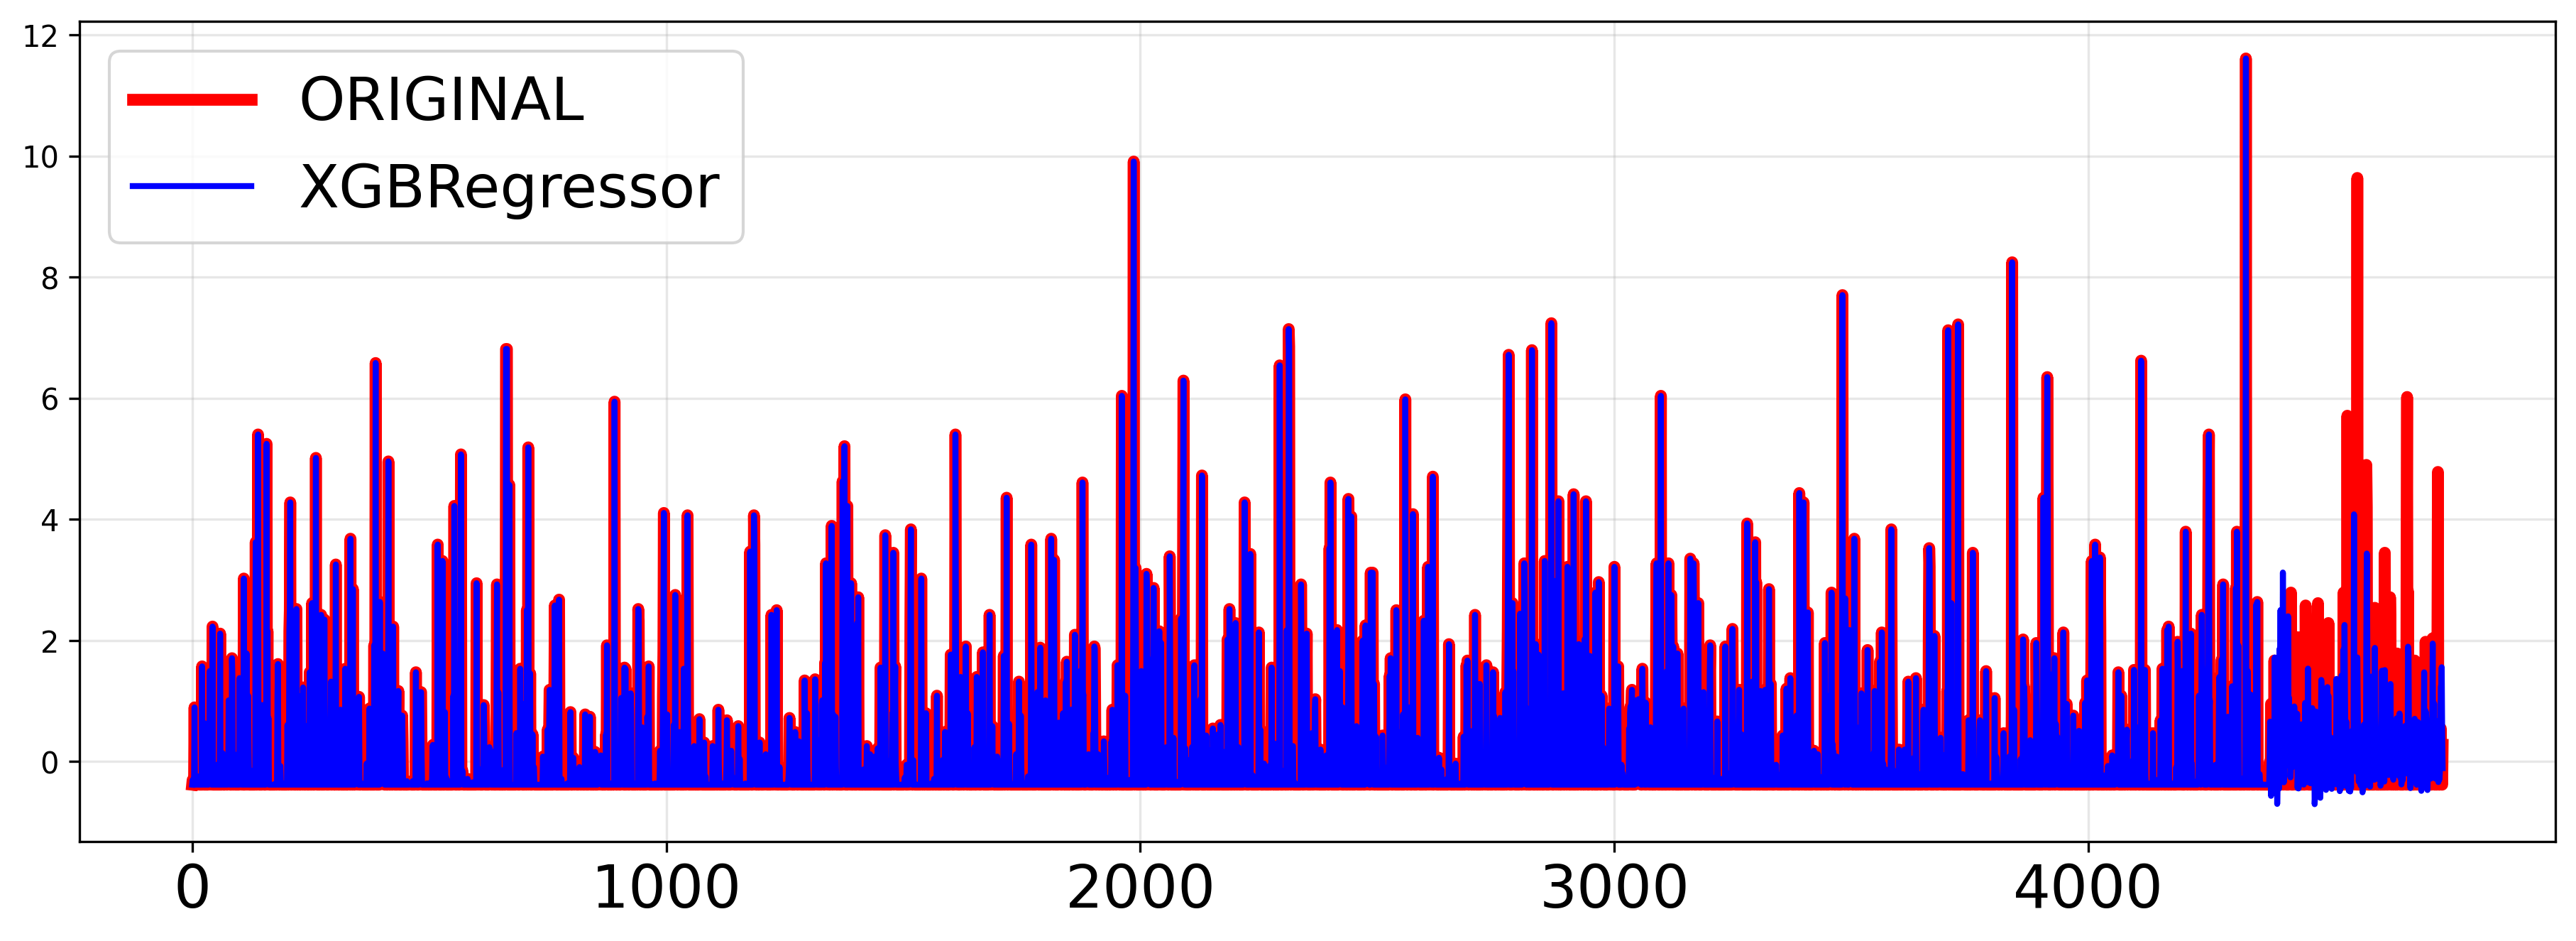

In [268]:
plot_grafico(series=[target_total_period, df_period_xgb['target']], labels=['ORIGINAL', 'XGBRegressor'], lw_list=[4, 2], colors=['red', 'blue'])

In [269]:
predicted_value_xgbregressor = df_period_xgb.iloc[-365:]['target'].apply(lambda x : x[0])

In [270]:
print_metricas_avaliacao(original_value, predicted_value_xgbregressor)

MAE: 0.6728251351798756
MSE: 1.1833576386623692
RMSE: 1.0878224297477825
R2: 0.027910194666775023


In [271]:
original_value.describe()

count    365.000000
mean       0.093797
std        1.104843
min       -0.379869
25%       -0.379869
50%       -0.379869
75%       -0.031655
max        9.640940
Name: target, dtype: float64

## Linear Regression

In [277]:
df_period_linear_regression = predicao(sw_df, start_period_train, end_period_train, num_predict_periods, sliding_window_size, 'linear_regression')

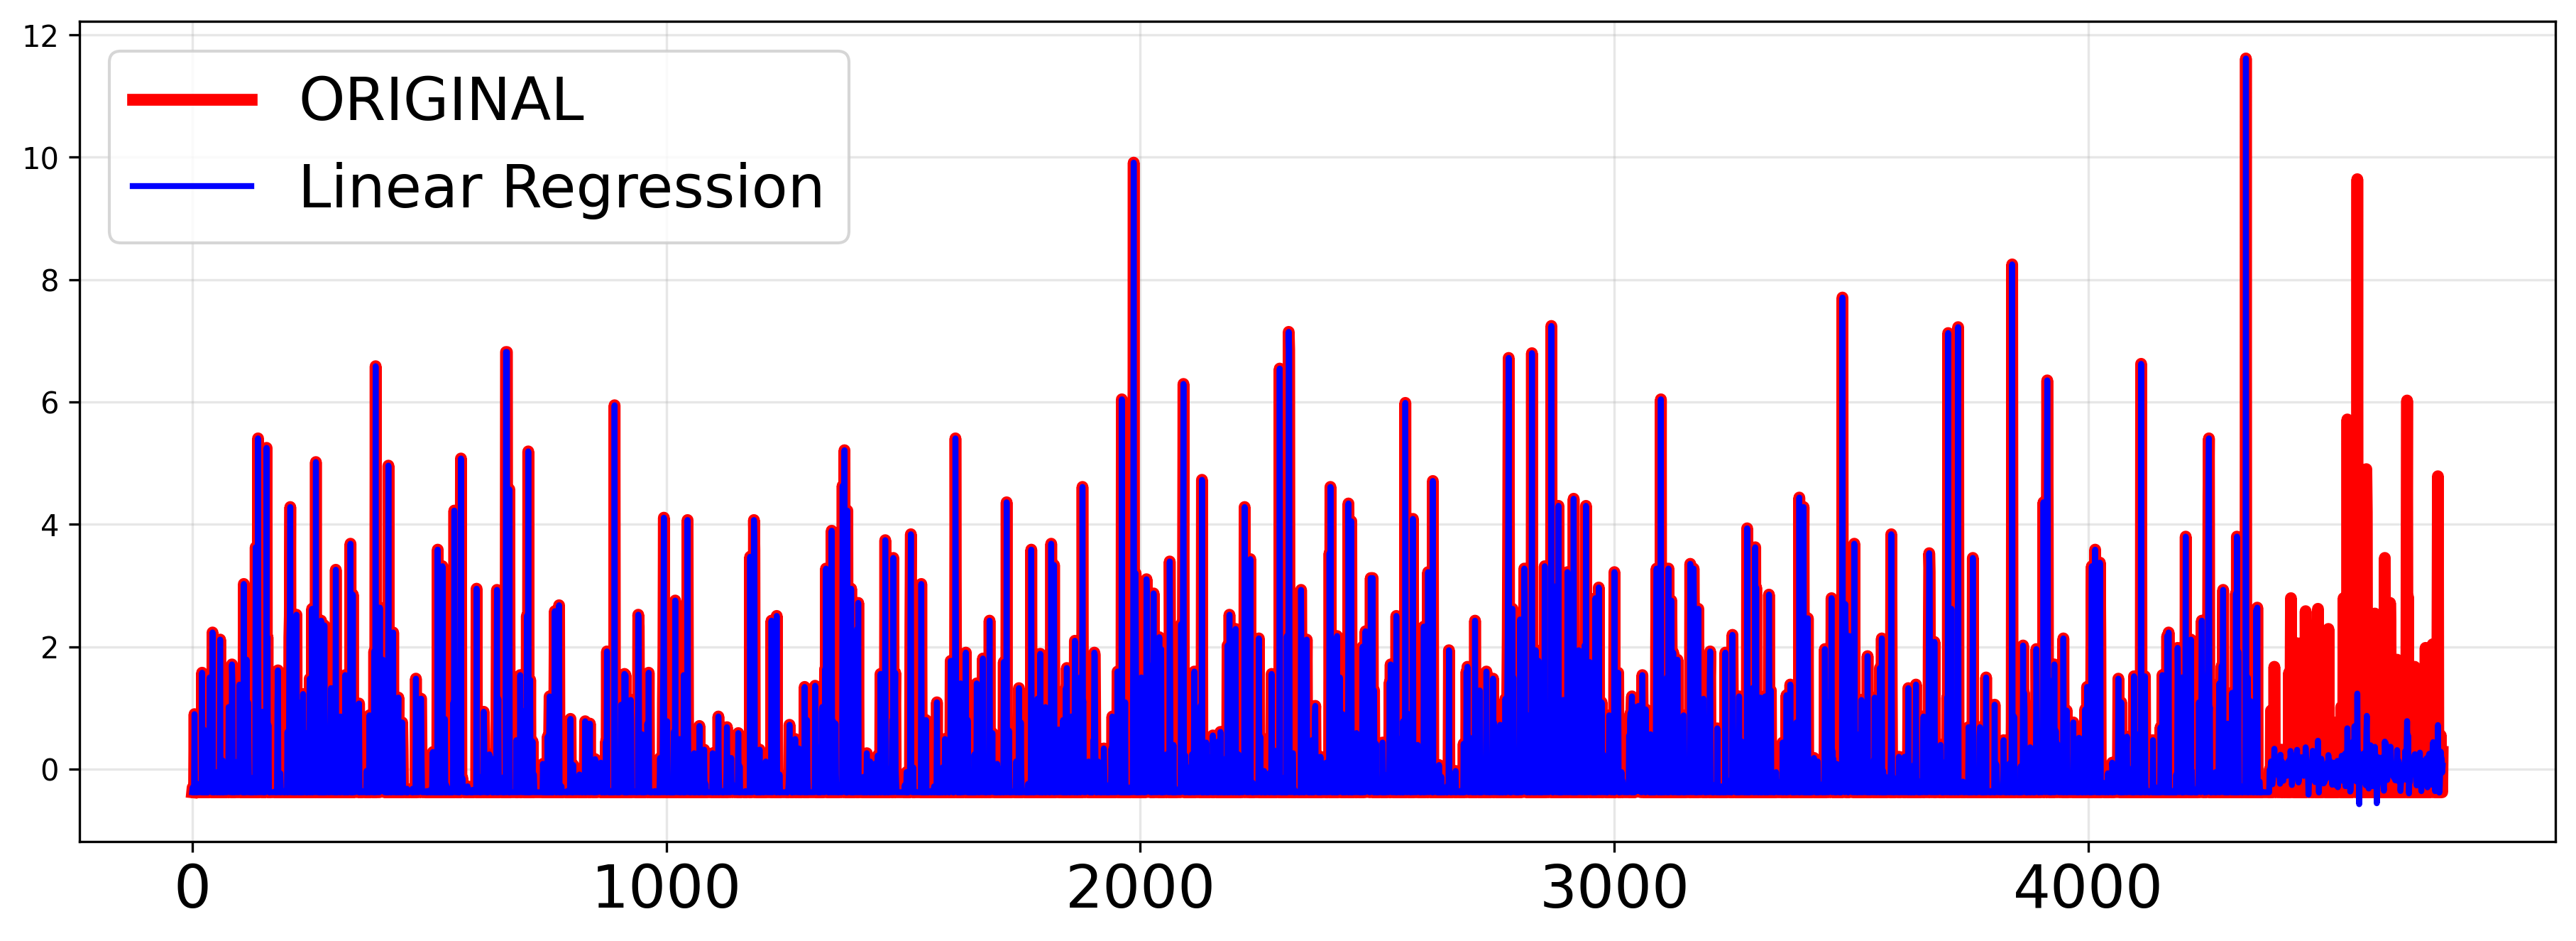

In [278]:
plot_grafico(series=[target_total_period, df_period_linear_regression['target']], labels=['ORIGINAL', 'Linear Regression'], lw_list=[4, 2], colors=['red', 'blue'])

In [279]:
predicted_value_linear_regression = df_period_linear_regression.iloc[-365:]['target'].apply(lambda x : x[0])

In [280]:
print_metricas_avaliacao(original_value, predicted_value_linear_regression)

MAE: 0.5205198990955858
MSE: 0.9222970570044334
RMSE: 0.9603629819002987
R2: 0.24236297015305985


In [281]:
original_value.describe()

count    365.000000
mean       0.093797
std        1.104843
min       -0.379869
25%       -0.379869
50%       -0.379869
75%       -0.031655
max        9.640940
Name: target, dtype: float64

## Random Forest

In [286]:
df_period_random_forest = predicao(sw_df, start_period_train, end_period_train, num_predict_periods, sliding_window_size, 'random_forest')

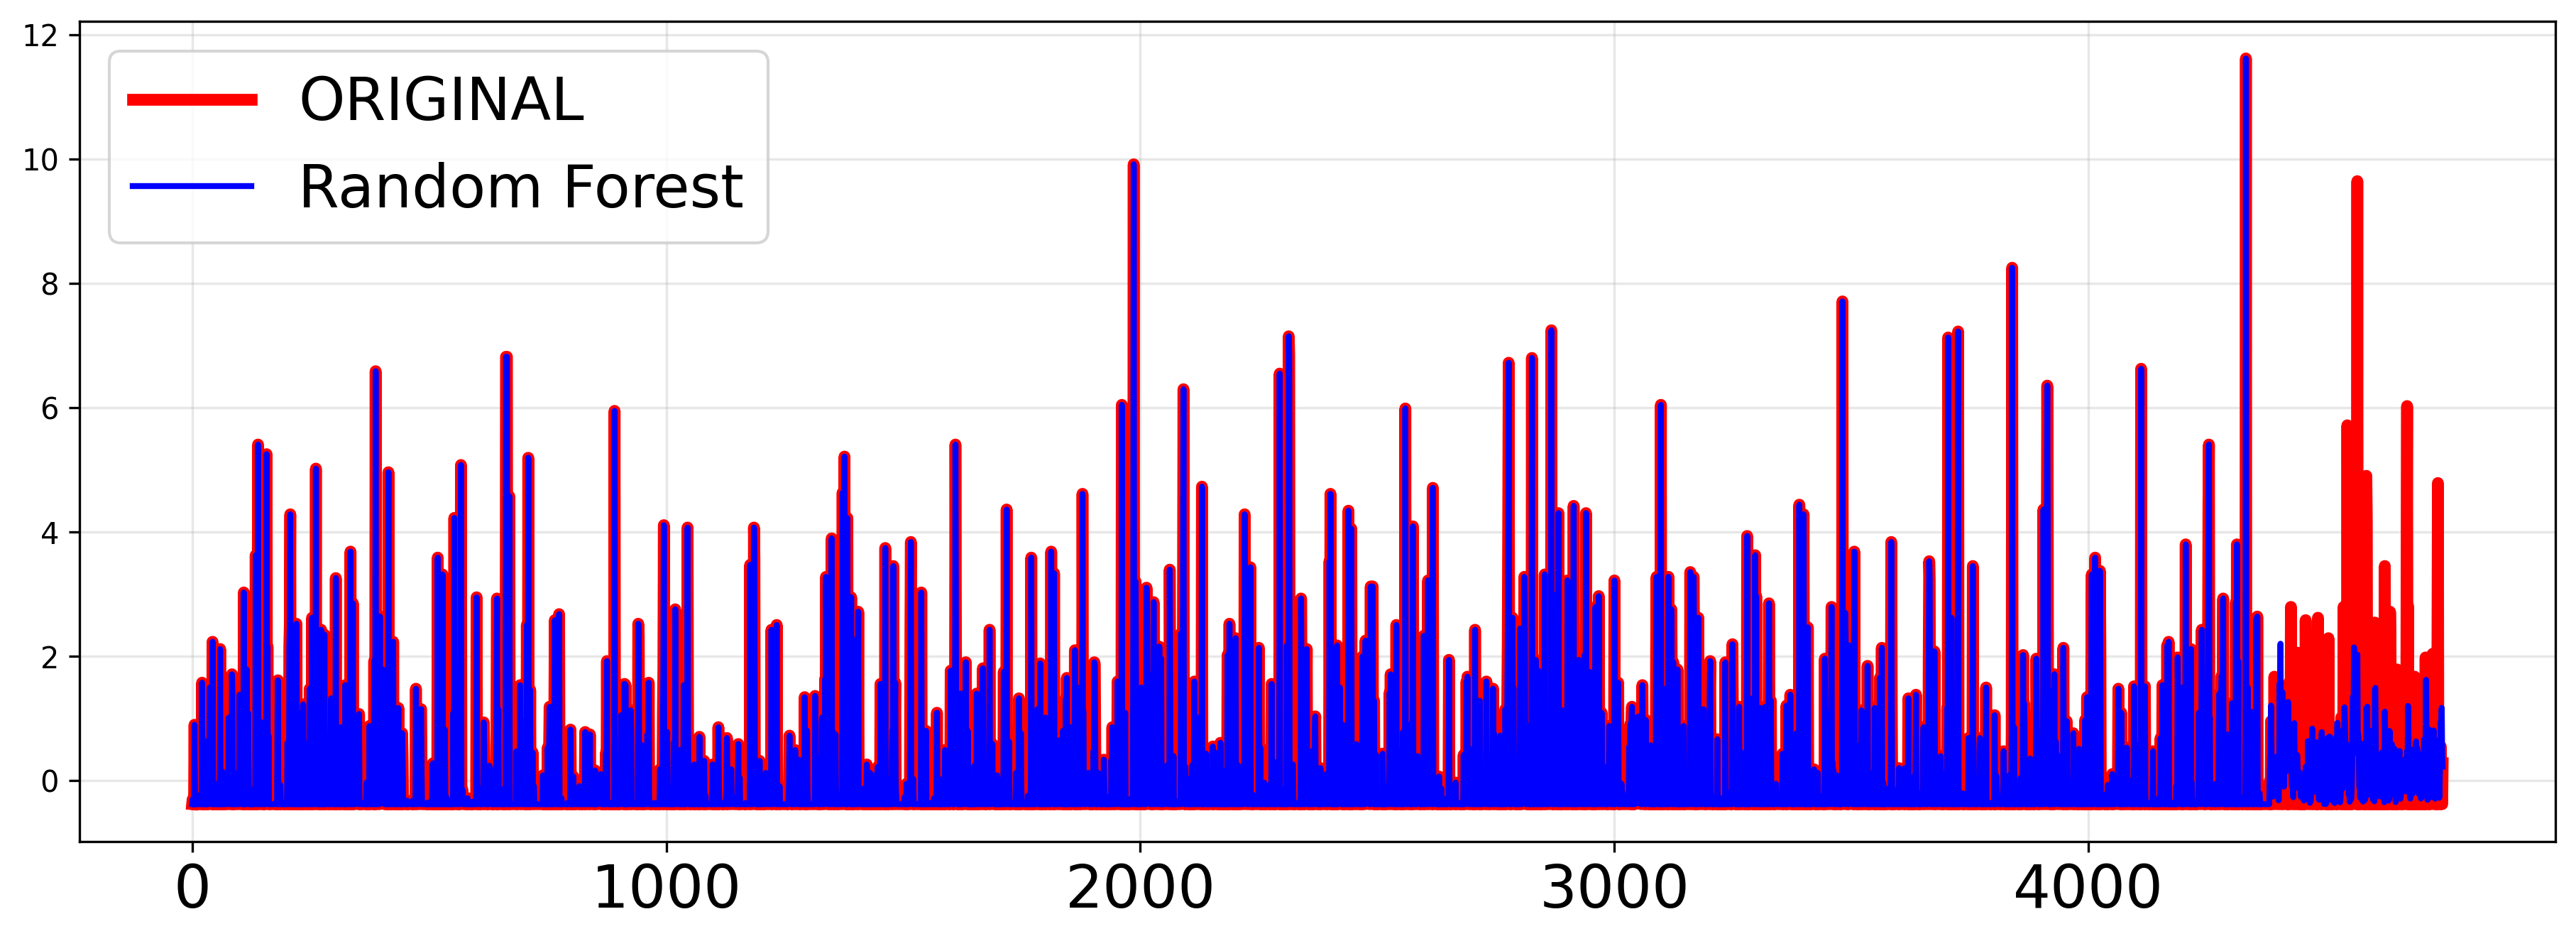

In [287]:
plot_grafico(series=[target_total_period, df_period_random_forest['target']], labels=['ORIGINAL', 'Random Forest'], lw_list=[4, 2], colors=['red', 'blue'])

In [288]:
predicted_value_random_forest = df_period_random_forest.iloc[-365:]['target'].apply(lambda x : x[0])

In [289]:
print_metricas_avaliacao(original_value, predicted_value_random_forest)

MAE: 0.6240282908855335
MSE: 1.0356984636719568
RMSE: 1.0176927157408353
R2: 0.14920740354299056


In [290]:
original_value.describe()

count    365.000000
mean       0.093797
std        1.104843
min       -0.379869
25%       -0.379869
50%       -0.379869
75%       -0.031655
max        9.640940
Name: target, dtype: float64

## Neural Networks

In [273]:
def plot_figure(x, y, xlabel, ylabel, title, xsticks, selection):

    plt.figure(figsize=(20,12))  # Optional: specify the figure size

    # Plotting
    plt.plot(x, y, marker='o', linestyle='-')
    plt.xticks(x[selection], xsticks[selection])

    # Adding labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Display the plot
    plt.grid(True)  # Optional: add gridlines
    plt.show()

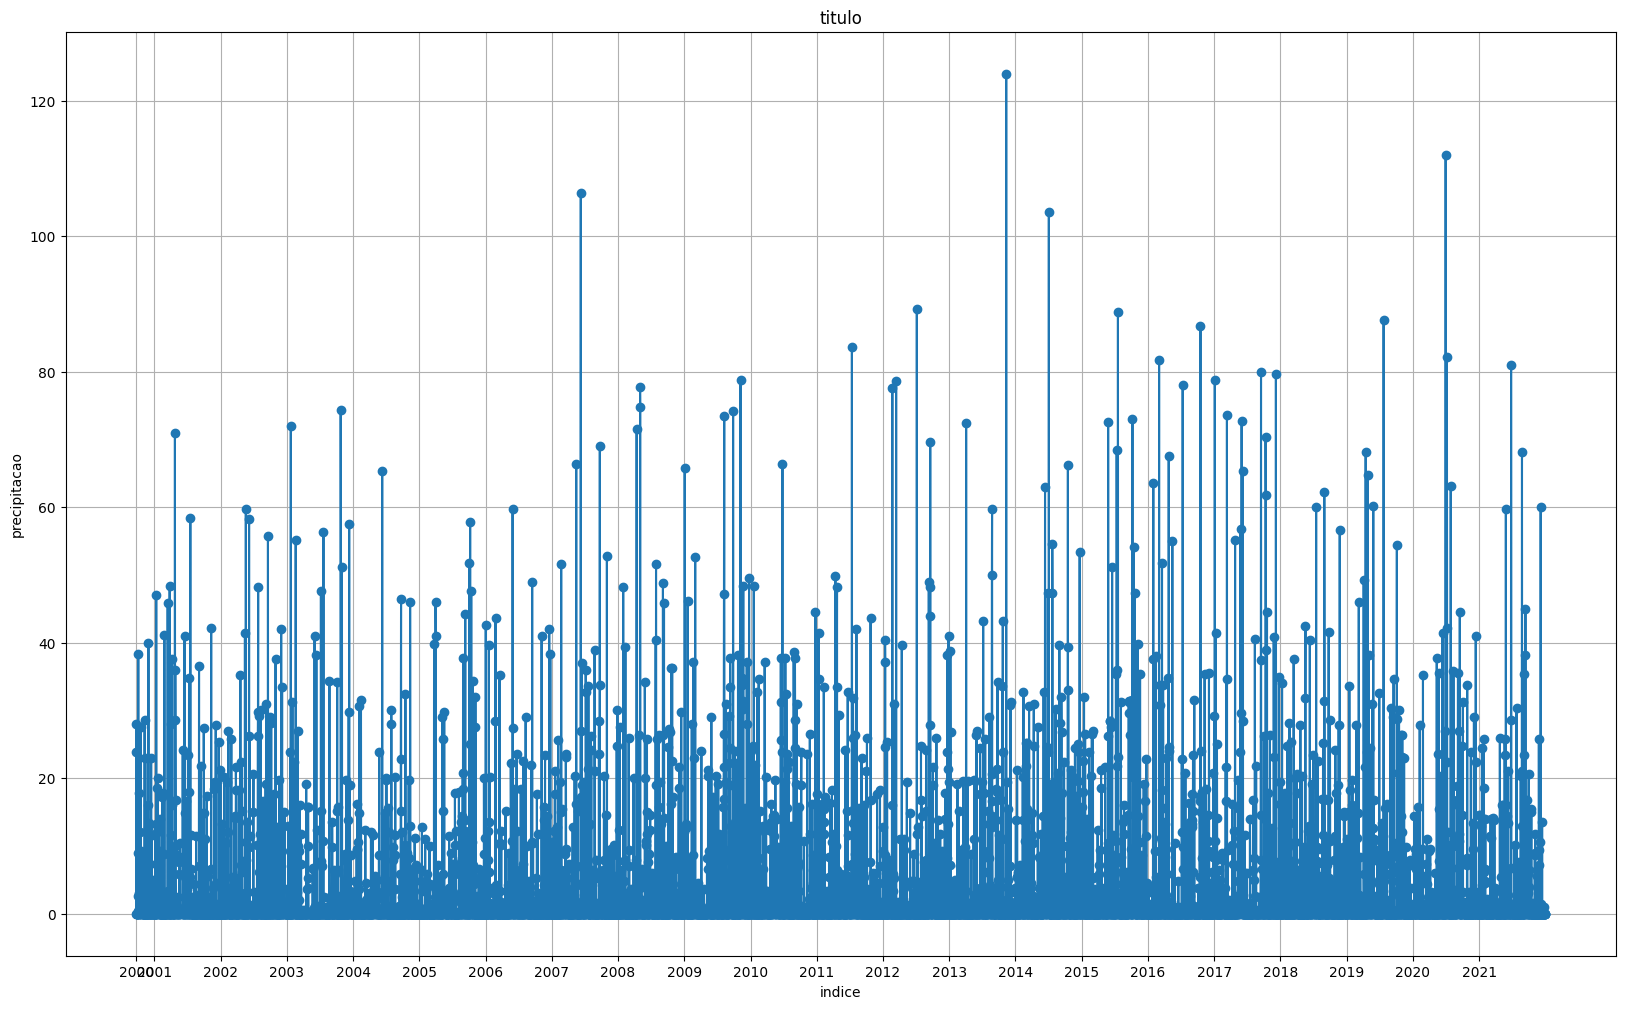

In [274]:
year_changes = daily_df['year'].diff().ne(0)

plot_figure(daily_df.index, daily_df['precipitacao'], 'indice', 'precipitacao', 'titulo', daily_df['year'], year_changes)

In [275]:
def sliding_windows_df(df, window_size=1):
    sw_df = df[window_size : : 1]
    
    set_of_features_sliding_window = {'radiacao_global_mean', 'radiacao_global_max', 'umidade_mean', 'umidade_min', 'umidade_max', 'umidade_median', 'vento_rajada_maxima_max'}
    target = 'precipitacao_sum'
    
    for i in range(1, window_size+1):
        feature_name = f'{target}_{i}'
        sw_df[feature_name] = df[target].shift(i)
        
        for feature in set_of_features_sliding_window:
            feature_name = f'{feature}_{i}'
            sw_df[feature_name] = df[feature].shift(i)
    
    return sw_df            

In [276]:
sw_df = sliding_windows_df(daily_df, 7)

KeyError: 'precipitacao_sum'

In [ ]:
sw_df.head()

In [ ]:
len(sw_df)

In [ ]:
len(daily_df)